In [134]:
import yfinance as yf
import pandas as pd
import ta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import numpy as np


In [135]:

# Fetch historical data for Bitcoin (BTC-USD)
crypto = 'BTC-USD'
data = yf.download(crypto, start="2018-01-01", interval='1d')
data = ta.add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

[*********************100%%**********************]  1 of 1 completed
c:\Users\syeds\anaconda3\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [136]:
# read fundamental indicators
fred_fundamental_data = pd.read_csv('fred_fundamental_data.csv', index_col="Unnamed: 0")
fred_fundamental_data = fred_fundamental_data.dropna()
fred_fundamental_data.index = pd.to_datetime(fred_fundamental_data.index)
fred_fundamental_data.tail()

,SP500,CUSR0000SETA01,CUSR0000SAF11,CORESTICKM159SFRBATL,CPILFESL,CPIAUCSL,MEDCPIM158SFRBCLE,PCEPILFE,CRESTKCPIXSLTRM159SFRBATL,CPALTT01USM657N,...,CUSR0000SEHA,CPIUFDSL,USACPALTT01CTGYM,T10YIE,T5YIE,T5YIFR,EXPINF30YR,WPSFD4131,MICH,CUSR0000SETA02.1
2024-07-25,5399.22,177.034,305.465,4.226876,318.346,313.049,2.364665,122.324,3.076544,0.646417,...,419.227,329.524,2.477751,2.28,2.13,2.43,2.466507,252.502,3.0,178.831
2024-07-26,5459.10,177.034,305.465,4.226876,318.346,313.049,2.364665,122.324,3.076544,0.646417,...,419.227,329.524,2.477751,2.27,2.13,2.41,2.466507,252.502,3.0,178.831
2024-07-29,5463.54,177.034,305.465,4.226876,318.346,313.049,2.364665,122.324,3.076544,0.646417,...,419.227,329.524,2.477751,2.25,2.13,2.37,2.466507,252.502,3.0,178.831
2024-07-30,5436.44,177.034,305.465,4.226876,318.346,313.049,2.364665,122.324,3.076544,0.646417,...,419.227,329.524,2.477751,2.25,2.12,2.38,2.466507,252.502,3.0,178.831
2024-07-31,5436.44,177.034,305.465,4.226876,318.346,313.049,2.364665,122.324,3.076544,0.646417,...,419.227,329.524,2.477751,2.24,2.13,2.35,2.466507,252.502,3.0,178.831


In [137]:
# concant to dataframes
data = pd.concat([ data, fred_fundamental_data], axis=1, )
data = data.ffill()
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,CUSR0000SEHA,CPIUFDSL,USACPALTT01CTGYM,T10YIE,T5YIE,T5YIFR,EXPINF30YR,WPSFD4131,MICH,CUSR0000SETA02.1
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,1.029120e+10,5.105295e+08,1.029120e+10,0.049608,0.000000e+00,...,314.531,252.377,2.042188,1.96,1.86,2.06,2.242314,201.0,2.7,138.559
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,1.684660e+10,1.052543e+10,2.713780e+10,0.387851,2.232005e+13,...,314.531,252.377,2.042188,2.00,1.90,2.10,2.242314,201.0,2.7,138.559
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,1.687190e+10,1.017099e+10,4.400970e+10,0.231108,1.965908e+13,...,314.531,252.377,2.042188,1.98,1.87,2.09,2.242314,201.0,2.7,138.559
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,2.178320e+10,2.692661e+10,6.579290e+10,0.409263,1.808979e+13,...,314.531,252.377,2.042188,2.01,1.92,2.10,2.242314,201.0,2.7,138.559
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,2.384090e+10,4.551422e+10,8.963380e+10,0.507780,2.173925e+13,...,314.531,252.377,2.042188,2.01,1.95,2.07,2.242314,201.0,2.7,138.559


In [138]:
data.shape

(2404, 114)

In [139]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi',
       ...
       'CUSR0000SEHA', 'CPIUFDSL', 'USACPALTT01CTGYM', 'T10YIE', 'T5YIE',
       'T5YIFR', 'EXPINF30YR', 'WPSFD4131', 'MICH', 'CUSR0000SETA02.1'],
      dtype='object', length=114)

In [140]:
# create a rolling 7 day return target
data['7day_return'] = data['Close'].pct_change(7).shift(-7)
data.dropna(inplace=True)


In [141]:
data['7day_return'] = data['7day_return'].apply(lambda x: 1 if x > 0 else 0)

In [142]:
data.drop(['Open', 'High', 'Low', 'Close','Adj Close', 'Volume'], axis=1, inplace=True)


In [143]:
# Drop rows with NaN values
data.dropna(inplace=True)

In [144]:
data.columns

Index(['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi',
       ...
       'CPIUFDSL', 'USACPALTT01CTGYM', 'T10YIE', 'T5YIE', 'T5YIFR',
       'EXPINF30YR', 'WPSFD4131', 'MICH', 'CUSR0000SETA02.1', '7day_return'],
      dtype='object', length=109)

In [145]:
x, y = data.drop('7day_return', axis=1), data['7day_return']

print(x.shape, y.shape)

(2397, 108) (2397,)


In [146]:
# split to train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=False)



In [147]:
y_train = y_train.reset_index(drop=True)

In [148]:
x_train = x_train.reset_index(drop = True)

In [149]:
x_train

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,...,CUSR0000SEHA,CPIUFDSL,USACPALTT01CTGYM,T10YIE,T5YIE,T5YIFR,EXPINF30YR,WPSFD4131,MICH,CUSR0000SETA02.1
0,5.105295e+08,1.029120e+10,0.049608,0.000000e+00,0.000000,0.000000,0.000000e+00,13641.366862,50.000000,1000.000000,...,314.531,252.377,2.042188,1.96,1.86,2.06,2.242314,201.000,2.7,138.559
1,1.052543e+10,2.713780e+10,0.387851,2.232005e+13,9080.474968,9080.474968,1.634306e+09,14193.074265,100.000000,1000.000000,...,314.531,252.377,2.042188,2.00,1.90,2.10,2.242314,201.000,2.7,138.559
2,1.017099e+10,4.400970e+10,0.231108,1.965908e+13,3904.621266,6492.548117,1.880818e+09,14581.435645,100.000000,1000.000000,...,314.531,252.377,2.042188,1.98,1.87,2.09,2.242314,201.000,2.7,138.559
3,2.692661e+10,6.579290e+10,0.409263,1.808979e+13,-434.276848,4183.606462,2.451444e+09,14815.050209,100.000000,1000.000000,...,314.531,252.377,2.042188,2.01,1.92,2.10,2.242314,201.000,2.7,138.559
4,4.551422e+10,8.963380e+10,0.507780,2.173925e+13,13887.051089,6609.467619,5.248766e+09,15337.468034,100.000000,1000.000000,...,314.531,252.377,2.042188,2.01,1.95,2.07,2.242314,201.000,2.7,138.559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,4.027983e+12,1.485849e+12,0.051959,4.558018e+12,-1357.143606,874.835493,6.975885e+10,22848.247484,69.623421,268.121812,...,370.998,308.020,8.461734,2.53,2.73,2.33,2.365091,238.270,5.2,206.552
1673,4.040269e+12,1.459999e+12,0.110594,3.823057e+12,-1156.635405,620.859972,6.973371e+10,22947.215242,63.050468,268.121812,...,373.742,310.595,8.214999,2.51,2.72,2.30,2.277917,239.483,4.8,204.837
1674,4.033468e+12,1.431610e+12,0.048775,1.913890e+12,-286.135909,319.262282,6.932447e+10,22956.743045,54.760119,268.121812,...,373.742,310.595,8.214999,2.48,2.69,2.27,2.277917,239.483,4.8,204.837
1675,4.013424e+12,1.405322e+12,-0.013165,1.146224e+12,318.192369,158.704294,6.917390e+10,22909.276015,52.856591,266.586119,...,373.742,310.595,8.214999,2.50,2.72,2.28,2.277917,239.483,4.8,204.837


In [152]:
len(x_train.columns)

108

In [116]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

#Perform Boruta
rf = RandomForestClassifier()
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=100)
feat_selector.fit(x_train.values, y_train.values)


BorutaPy(estimator=RandomForestClassifier(n_estimators=131,
                                          random_state=RandomState(MT19937) at 0x16AA5E93E40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x16AA5E93E40)

In [133]:
len(x_train.columns)

62

In [127]:
len(x_train.columns)

62

In [132]:
len([ True,  True,  True,  True, False,  True,  True, False, False,
        True, False,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False,  True, False, False, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True, False, False,  True,
       False, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True,  True,  True, False, False, False])

108

In [125]:
indexes

(array([  0,   1,   2,   3,   5,   6,   9,  11,  12,  13,  14,  19,  20,
         21,  25,  27,  28,  29,  30,  31,  32,  33,  35,  37,  41,  42,
         44,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         60,  65,  69,  70,  71,  73,  74,  75,  76,  77,  78,  79,  80,
         82,  85,  86,  89,  94,  97, 101, 102, 103, 104], dtype=int64),)

In [153]:

#List on New Features
features = [f for f in x_train.columns]
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print('Final Features')
print('\n',final_features)

Final Features

 ['volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp', 'volatility_dch', 'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_slow', 'trend_ema_slow', 'trend_trix', 'trend_mass_index', 'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_ind', 'momentum_rsi', 'momentum_tsi', 'momentum_uo', 'momentum_stoch', 'momentum_wr', 'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal', 'momentum_kama', 'others_cr', 'SP500', 'CORESTICKM159SFRBATL', 'CRESTKCPIXSL

In [154]:
x_train = x_train[final_features]
x_test = x_test[final_features]

In [159]:
x_train


,volume_adi,volume_obv,volume_cmf,volume_fi,volume_sma_em,volume_vpt,volume_nvi,volatility_bbh,volatility_bbl,volatility_bbw,...,momentum_kama,others_cr,SP500,CORESTICKM159SFRBATL,CRESTKCPIXSLTRM159SFRBATL,STICKCPIM157SFRBATL,T10YIE,T5YIE,T5YIFR,EXPINF30YR
0,5.105295e+08,1.029120e+10,0.049608,0.000000e+00,0.000000,0.000000e+00,1000.000000,13657.200195,13657.200195,0.000000,...,13657.200195,0.000000,2673.61,2.157823,1.056337,0.29694,1.96,1.86,2.06,2.242314
1,1.052543e+10,2.713780e+10,0.387851,2.232005e+13,9080.474968,1.634306e+09,1000.000000,15644.549316,12994.750488,18.504634,...,14215.430782,9.701106,2695.81,2.157823,1.056337,0.29694,2.00,1.90,2.10,2.242314
2,1.017099e+10,4.400970e+10,0.231108,1.965908e+13,6492.548117,1.880818e+09,1000.000000,15977.511089,13249.355448,18.668821,...,14616.383973,11.303926,2713.06,2.157823,1.056337,0.29694,1.98,1.87,2.09,2.242314
3,2.692661e+10,6.579290e+10,0.409263,1.808979e+13,4183.606462,2.451444e+09,1000.000000,16317.384366,13402.365634,19.616711,...,15010.941835,14.219606,2723.99,2.157823,1.056337,0.29694,2.01,1.92,2.10,2.242314
4,4.551422e+10,8.963380e+10,0.507780,2.173925e+13,6609.467619,5.248766e+09,1000.000000,17808.008153,12939.591847,31.666968,...,15934.587313,27.621326,2743.15,2.157823,1.056337,0.29694,2.01,1.95,2.07,2.242314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,4.027983e+12,1.485849e+12,0.051959,4.558018e+12,874.835493,6.975885e+10,268.121812,24787.352142,19527.310749,23.739508,...,21973.271190,70.876140,4130.29,5.590730,5.308432,0.51157,2.53,2.73,2.33,2.365091
1673,4.040269e+12,1.459999e+12,0.110594,3.823057e+12,620.859972,6.973371e+10,268.121812,24684.892718,20028.798688,20.826256,...,21998.884484,70.709947,4118.63,5.951312,5.573084,0.59382,2.51,2.72,2.30,2.277917
1674,4.033468e+12,1.431610e+12,0.048775,1.913890e+12,319.262282,6.932447e+10,268.121812,24616.581252,20373.714451,18.861253,...,22014.545470,68.249106,4091.19,5.951312,5.573084,0.59382,2.48,2.69,2.27,2.277917
1675,4.013424e+12,1.405322e+12,-0.013165,1.146224e+12,158.704294,6.917390e+10,266.586119,24540.826463,20677.128029,17.089223,...,22021.782436,67.285443,4155.17,5.951312,5.573084,0.59382,2.50,2.72,2.28,2.277917


In [155]:

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))


Accuracy: 0.4666666666666667
              precision    recall  f1-score   support

           0       0.46      0.78      0.58       334
           1       0.51      0.19      0.28       386

    accuracy                           0.47       720
   macro avg       0.48      0.49      0.43       720
weighted avg       0.48      0.47      0.42       720



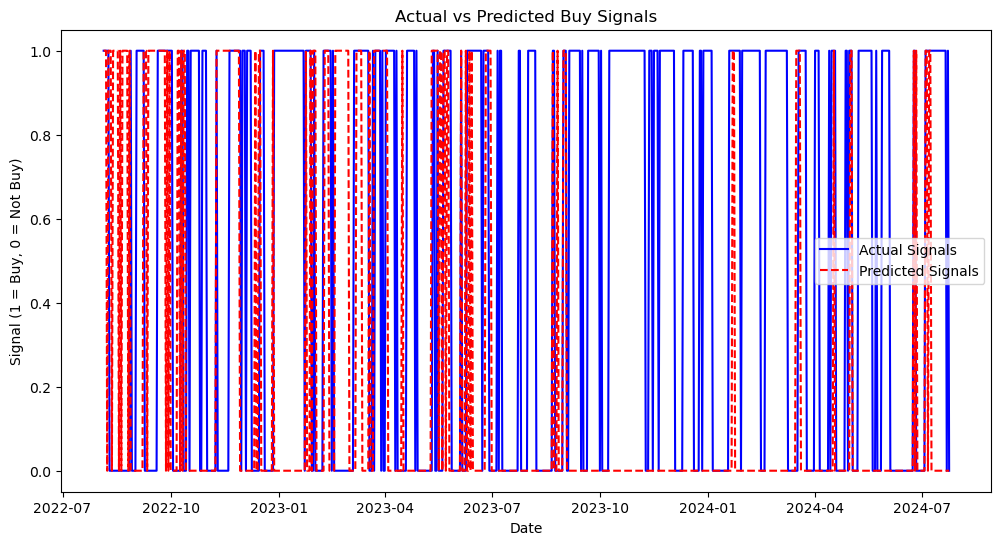

In [160]:

# Plot actual vs predicted signals
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Signals', color='b')
plt.plot(y_test.index, y_pred, label='Predicted Signals', color='r', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Signal (1 = Buy, 0 = Not Buy)')
plt.title('Actual vs Predicted Buy Signals')
plt.show()


In [161]:
signal = "Buy" if y_pred[-1] == 1 else "Sell"
print("Signal for this week is: ",signal)

Signal for this week is:  Sell


In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Hyperparameter tuning using GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Use GridSearchCV for RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(x_train, y_train)

print(f"Best parameters for RandomForest: {grid_search_rf.best_params_}")
print(f"Best score for RandomForest: {grid_search_rf.best_score_}")

# Train the RandomForest model with best parameters
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(x_test)

# Evaluate the RandomForest model
print(f"RandomForest Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

# Use GridSearchCV for GradientBoostingClassifier
grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid_gb, cv=5, scoring='accuracy')
grid_search_gb.fit(x_train, y_train)

print(f"Best parameters for GradientBoosting: {grid_search_gb.best_params_}")
print(f"Best score for GradientBoosting: {grid_search_gb.best_score_}")

# Train the GradientBoosting model with best parameters
best_model_gb = grid_search_gb.best_estimator_
y_pred_gb = best_model_gb.predict(x_test)

# Evaluate the GradientBoosting model
print(f"GradientBoosting Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))